### PyTorch Workflow

#### Topics:
1. Data (prepare and load)
2. Build model
3. Fitting the model to data (training)
4. Making predictions and evaluating a model (inference)  
5. Saving and loading a model
6. Putting it all together

In [57]:
import torch
from torch import nn ##nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Check PyTorch version
torch.__version__



'2.7.1+cpu'

### 1. Data (Preparing and loading)

Data can be almost anything... in machine learning
Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation


In [58]:
# Create known paramenters
# f = wx + b
weight = 0.7
bias = 0.3

#Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)

y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [59]:
len(X),len(y)

(50, 50)

### Splitting data into training and test sets 

In [60]:
# Create a train/test split 
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

X_test


tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [61]:
def plot_predictions(train_data = X_train,
                     train_label=y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
    """
    Plots training data, test data and compares predictions
    """

    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_label,c="b",s=4,label="training data")

    plt.scatter(test_data,test_label,c="g",s=4,label="Testing data")

    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",label="Predictions")



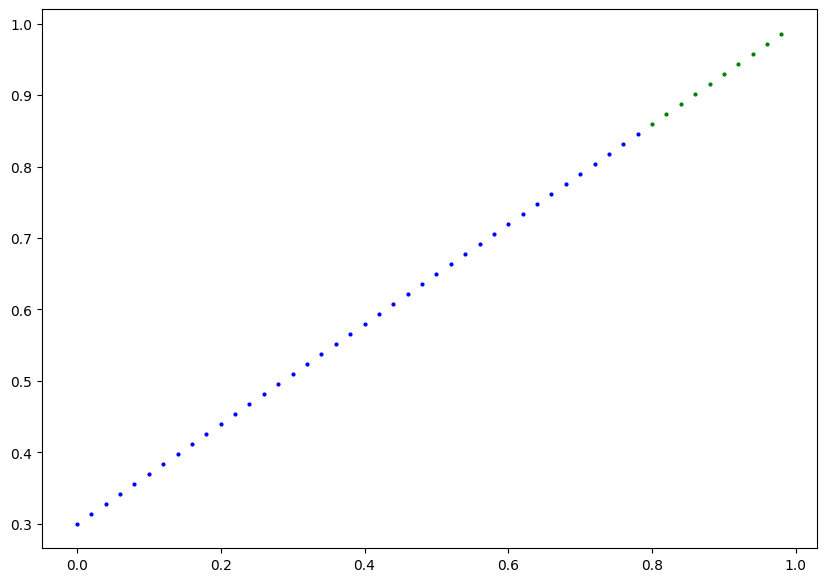

In [62]:
plot_predictions()

In [63]:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module (this contains all the building blocks for neural networks)
    #Base class for all neural network modules.
    #Your modles should also subclass this class
    
    
    
    def __init__(self):
        super().__init__()

        #Initialise model paramenters to be used in various computations (these could be different layers from torch.nn, single parameters, hard coded values or functions)
        self.weights = nn.Parameter(torch.randn(1, #Start with a random weight and try to adjust it to the ideal weight
                                                requires_grad=True, # Can this paramaneter be updated via gradient descent or not..
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, #Start with a random bias and try to adjust it to the ideal bias
                                             requires_grad=True, # Can this paramaneter be updated via gradient descent or not..
                                             dtype=torch.float32))
        # Requires grad = true means Pytorch will track the gradients of this specific paramenter for use with torch.autograd and gradient descent (for many torch.nn modeules, 
        #                                                                                                                                           required_grad = True is set by default))

    #Forward method to define the computation in the model
    def forward(self,x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # This is the linear regression formula
    #Any subclass of nn.Module needs to override forward() (This defines the forward computation of the model)

    



### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite the forward() method
* torch.optim - This is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward, this method defines what happens in the forward computation
* torch.utils.data.Dataset - Represents a map between key and sample pairs of data, such as images and their associated labels
* torch.utils.data.DatLoader - creates a Python iterable over a torch Dataset (allow you to iterate over your data)

### Checking the contents of our PyTorch model

Now we have created our model, let's see what is inside...

We can check out our model parameter or what is inside our model using `.parameter()`

In [64]:
# Create a random seed 

torch.manual_seed(42) 

# Create an instance of the model (this is a subclass of nn.Module)

model_0 = LinearRegressionModel() 

list(model_0.parameters())



[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

### Making predicitons using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When was pass data through our model its going to run it through the `forward()` method

In [65]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [66]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do something ismilar with torch.nograd(), however torch.inference_mode() is preffered
#with torch.no_grad():
    #y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

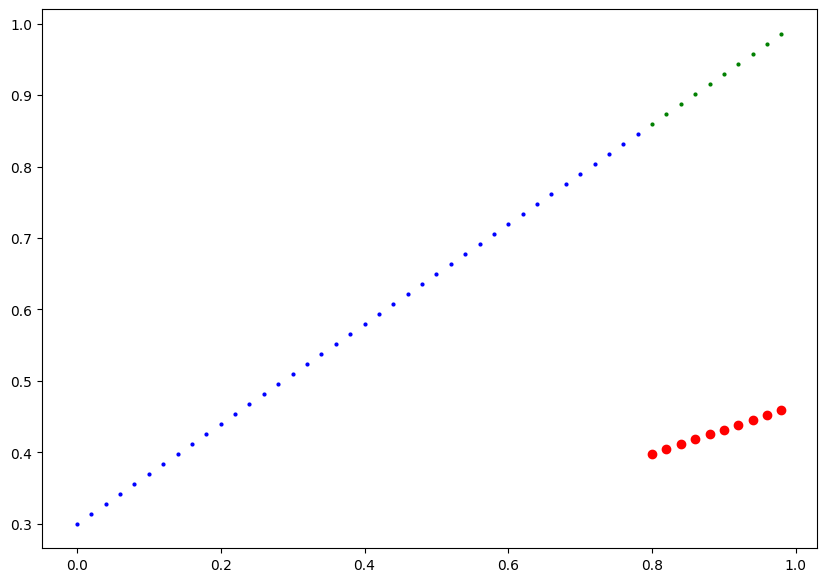

In [67]:
plot_predictions(predictions=y_preds)

### Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some known parameter

                                                        OR                                                                 

In other words from a poor representation of the data to a better representation of the data


* Note: Loss function may also be called cost function or criterion in different areas. For our casem we are going to refer to it as loss function

Things we need to train:

* **Loss Function:** A function to measure how wrong your model's predictions are to the ideal output. So lower is better
* **Optimizer:** Takes into account the loss of a model and ajusts the model's parameters to improve the loss function.
        
Inside the Optimizer you will often have to set two parameters:
* `params`: The model parameters you would like to optimize, for example, `params=model_0.parameters()` 
* `lr` (learning rate): The learning rate is a hypterparmeter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results   in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [68]:
# Setup a loss function
loss_fn = nn.L1Loss()
#Setup an Optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01) #Lr = learning rate

Q. Which loss function and optimizer should i use?
A. This will be a problem specific. But with expericne, you will get an idea of what works and what doesnt with your particular problem set

For example, for regression problem, a loss function of `mm.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice

But for a classification problem like classifying whether a photo is of a dog or a cat, you will likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss)

### Building a training loop and a testing loop

A couple of things we need in a training loop

0. Loop through the data
1. Forward pass (this involves data moving through our models `forward()` functions) to make predicitons on data - also called forward propogation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss Backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back propogation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

### The PyTorch Optimization loop song

Its train time!
Do the forward pass,
calculate the loss,
optimizer zero grad,
loss backwards!

Optimizer step step step

Let's test now!
with torch no grad:
do the forward pass,
calculate the loss,
watch it go down down down!

In [69]:
torch.manual_seed(42)

# An epoch is one loop through the data... (This is a hyper parameter because we have set it ourselves)
epochs = 200

# Track different values 
epoch_count = []
loss_values = []
test_loss_values = []



### Training
# 0. Loop through the data

for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients

# 1. Forward pass
    y_pred = model_0(X_train)

# 2. Calculate the loss
    loss = loss_fn(y_pred,y_train)

# 3. Optimizer zero grad
    optimizer.zero_grad()

# 4. Perform back propogation on the loss with respect to the parametrers of the model
    loss.backward()

#5. Step the optimizaer (perform gradient descent)
    optimizer.step() # By default how the optimizer changes will accumulate through the loop soo... we have to zero them above in step 3 for the next iteration of the loop

### Testing
    model_0.eval() #Turns off different settings in the model not needed for evaluation/testing
    with torch.inference_mode():
        #1. Do the foward pass
        test_pred = model_0(X_test)

        #2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        
        
        #3. 



print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test Loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test Loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test Loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test Loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test Loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test Loss: 0.03233227878808975
Ep

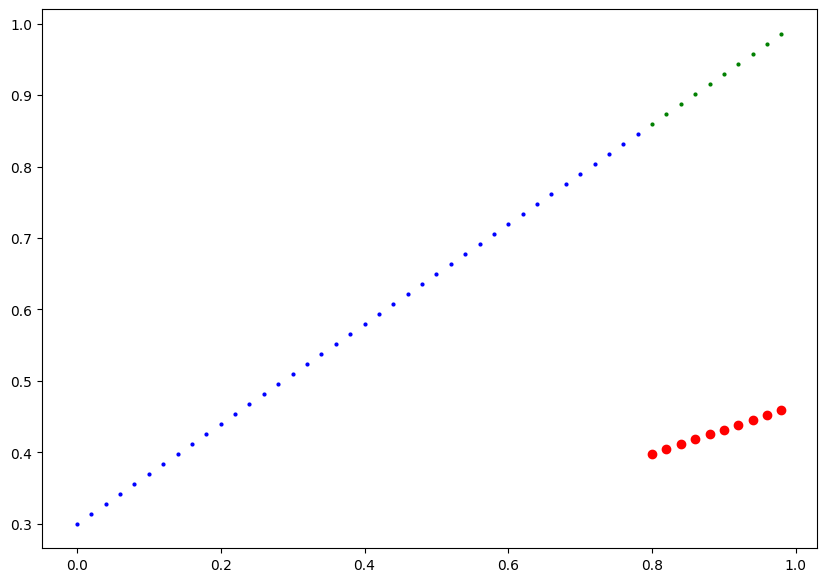

In [70]:
plot_predictions(predictions=y_preds)

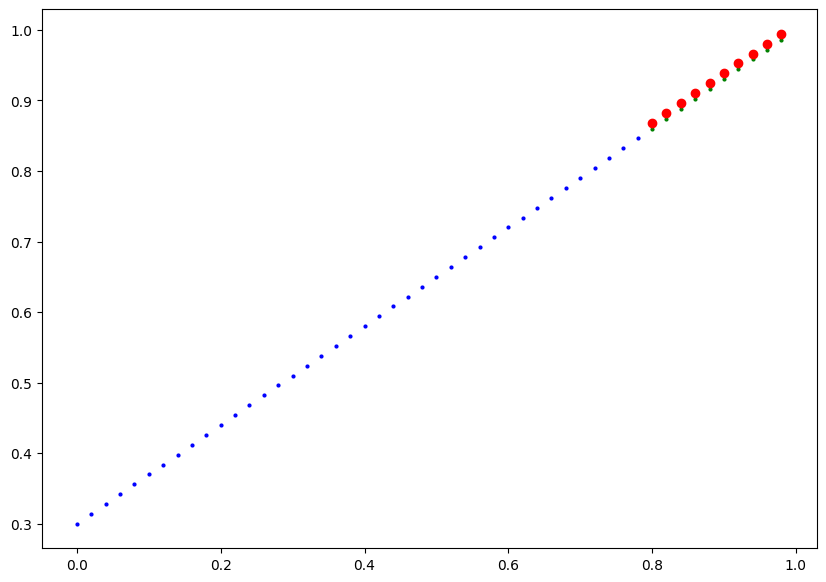

In [71]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)
    

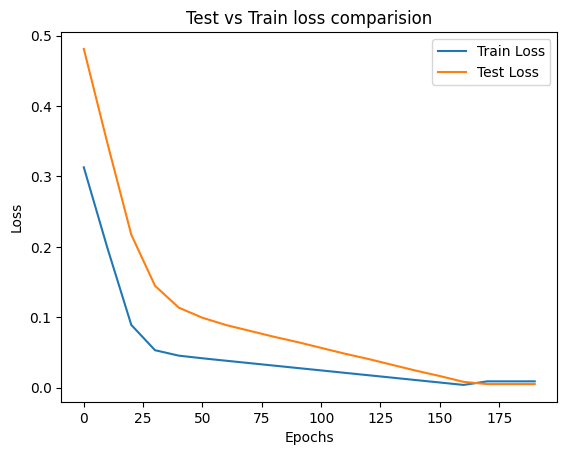

In [72]:
#Plot loss curves 
plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),label="Train Loss")
plt.plot(epoch_count,np.array(torch.tensor(test_loss_values).numpy()),label="Test Loss")
plt.title("Test vs Train loss comparision")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model in PyTorch

There are three main methods you should know about saving and loading models in PyTorch

1. `torch.save()` -  allows you to save a PyTorch object in a pickle format. This function uses Python's pickle utility for serialization. Modles,tensors and dictionaries of all kinds of objects can be saved using this function
2. `torch.load()` -  allows you to load a saved PyTorch Object.
3. `torch.nn.Module.load_save_dict()` -  This allows you to load a model's saved state dictionary. Loads a model's parameter dictionary uising a deserialized state_dict,

In [73]:
# Saving our PyTorch Model

from pathlib import Path

# 1. Create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2.Create model save path

MODEL_NAME = '01_PyTorch_Workflow_model_0.pth' #pytorch has extension pth. Common convention is to save models using either a .pt or .pth file extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\01_PyTorch_Workflow_model_0.pth


### Loading a PyTorch model

Since we saved our models `state_dict()` rather than the entire model we will create a new instance of our model class and load the saved `state_dict()` into that

In [74]:
# To load in a saved state_dict() we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0 (this will update the new instance with updated parameters)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [75]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

Create device - agnostic code.

This means if we have got a access to a GPU, out code will use it (For faster computing)
If no GPU is available, the will default to using GPU

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device :{device}")

Using device :cpu


### 6.1 Data


In [77]:
# Create some data using the linear regression formula of y = w * X + b

weight = 0.7
bias = 0.3

# Create range values
start = 0 
end = 1
step = 0.02

# Create X and y

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10],y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [78]:
# Spliot the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

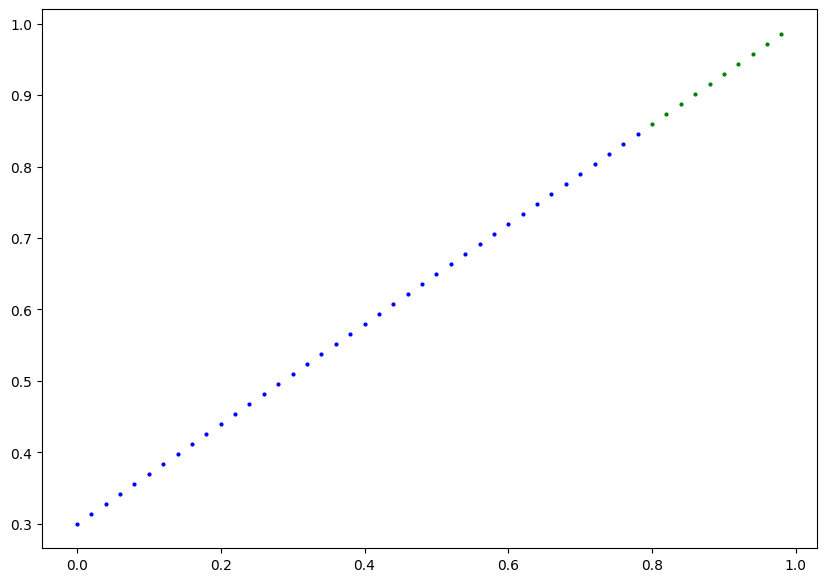

In [79]:
# Plot the data 

plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a PyTorch Linear Model

In [80]:
# Create a linear model by subclassing nn.module 

class LinearRegressionModelv2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected layer

        self.linear_layer = nn.Linear(in_features=1, #Input of size 1
                                      out_features=1) #Output of size 1
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set manual seed

torch.manual_seed(42)

model_1 = LinearRegressionModelv2()
model_1,model_1.state_dict()

(LinearRegressionModelv2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 6.3 Training

For training we need: 
* Loss Function
* Optimizer 
* Training loop
* Testing loop

In [82]:
# Setup Loss Function 

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr=0.01) #Learning rate


torch.manual_seed(42)

epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []




for epoch in range(epochs):
    # 1. Training mode
    model_1.train()

    # 2. Forward pass
    y_pred = model_1(X_train)

    # 3. Loss Function
    loss = loss_fn(y_pred,y_train)

    # 4. Optimizer zero grad
    optimizer.zero_grad()

    # 5. Back propogation
    loss.backward()

    # 6. Optimizer
    optimizer.step()

    
    # Testing the model
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred,y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test_Loss: {test_loss}")

print(model_1.state_dict())







Epoch: 0 | Loss: 0.5805944204330444 | Test_Loss: 0.7031320333480835
Epoch: 10 | Loss: 0.4653845727443695 | Test_Loss: 0.5684221982955933
Epoch: 20 | Loss: 0.3501747250556946 | Test_Loss: 0.4337123930454254
Epoch: 30 | Loss: 0.23496484756469727 | Test_Loss: 0.2990025281906128
Epoch: 40 | Loss: 0.11975497007369995 | Test_Loss: 0.16429266333580017
Epoch: 50 | Loss: 0.017513396218419075 | Test_Loss: 0.04365081340074539
Epoch: 60 | Loss: 0.01126673724502325 | Test_Loss: 0.025306349620223045
Epoch: 70 | Loss: 0.007835463620722294 | Test_Loss: 0.017720693722367287
Epoch: 80 | Loss: 0.004401929676532745 | Test_Loss: 0.009448152966797352
Epoch: 90 | Loss: 0.0045344093814492226 | Test_Loss: 0.010805266909301281
Epoch: 100 | Loss: 0.0045344093814492226 | Test_Loss: 0.010805266909301281
Epoch: 110 | Loss: 0.0045344093814492226 | Test_Loss: 0.010805266909301281
Epoch: 120 | Loss: 0.0045344093814492226 | Test_Loss: 0.010805266909301281
Epoch: 130 | Loss: 0.0045344093814492226 | Test_Loss: 0.01080526

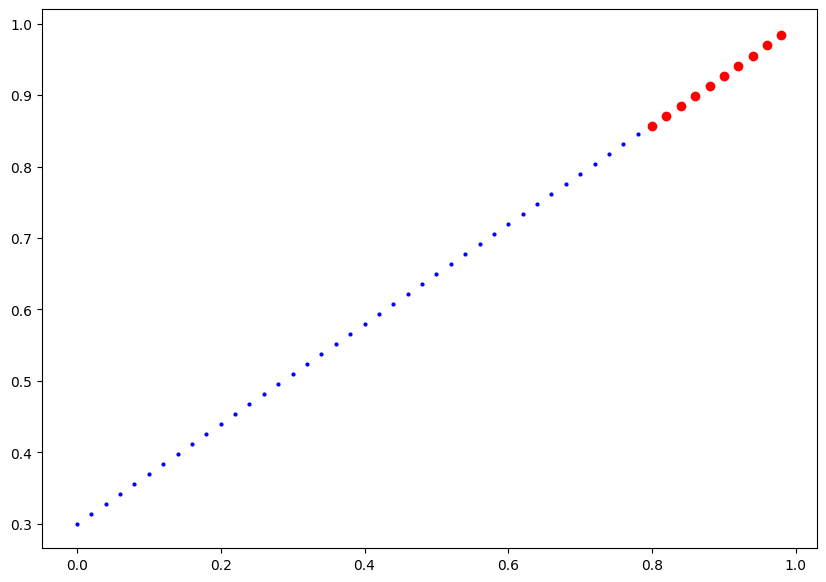

In [84]:
with torch.inference_mode():
    y_preds_new = model_1(X_test)
plot_predictions(predictions=y_preds_new)

### Saving the model

In [85]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = '02_PyTorch_Model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models\02_PyTorch_Model.pth
